In [635]:
import re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

# Data Loading

In [3]:
df = pd.read_csv("../cars.csv", sep=";", encoding="utf-16")

In [4]:
df.head()

,brand,currency,description,model,price,url,year,Город,Коробка передач,Кузов,"Объем двигателя, л",Привод,Растаможен,Руль,Цвет,Пробег,Наличие,VIN
0,Mercedes-Benz,₸,"полный электропакет , налог уплачен, техосмот...",GL 550,5800000,https://kolesa.kz/a/show/10235750,2008,Актау,типтроник,внедорожник,5.5 (бензин),полный привод,Да,слева,черный металлик,NaN,NaN,NaN
1,BMW,₸,"тонировка , обогрев зеркал, хрустальная оптик...",X5,5500000,https://kolesa.kz/a/show/10269314,2009,Нур-Султан (Астана),автомат,кроссовер,4.8 (бензин),полный привод,Да,слева,черный,170 км,NaN,NaN
2,Mercedes-Benz,₸,"лонг, состояние нового авто немец газ-бензин п...",S 350,7770000,https://kolesa.kz/a/show/1063798,2006,Алматы,типтроник,седан,3.5 (бензин),NaN,Да,слева,черный,60 000 км,NaN,NaN
3,Mitsubishi,₸,"литые диски, тонировка, люк , хрустальная опт...",Outlander,3200000,https://kolesa.kz/a/show/10695701,2003,Семей,типтроник,кроссовер,2.4 (бензин),полный привод,Да,слева,серебристый металлик,120 000 км,NaN,NaN
4,Ретро-автомобили,₸,"налог уплачен, техосмотр пройден, вложений не ...","ГАЗ 21 ""Волга""",3900000,https://kolesa.kz/a/show/10852142,1970,Алматы,механика,седан,2.4 (бензин),задний привод,Да,слева,черный,1 200 км,NaN,NaN


In [5]:
df.shape

(108536, 18)

# Data Cleaning

Приведем названия колонок к одному формату

In [6]:
df.rename(columns={"Город": "city", 
                   "Коробка передач": "transmission", 
                   "Кузов": "body", 
                   "Объем двигателя, л": "engine",
                   "Привод": "drive",
                   "Растаможен": "cleared",
                   "Руль": "wheel",
                   "Цвет": "color",
                   "Пробег": "mileage",
                   "Наличие": "stock"}, inplace=True)


In [7]:
df.head(2)

,brand,currency,description,model,price,url,year,city,transmission,body,engine,drive,cleared,wheel,color,mileage,stock,VIN
0,Mercedes-Benz,₸,"полный электропакет , налог уплачен, техосмот...",GL 550,5800000,https://kolesa.kz/a/show/10235750,2008,Актау,типтроник,внедорожник,5.5 (бензин),полный привод,Да,слева,черный металлик,NaN,NaN,NaN
1,BMW,₸,"тонировка , обогрев зеркал, хрустальная оптик...",X5,5500000,https://kolesa.kz/a/show/10269314,2009,Нур-Султан (Астана),автомат,кроссовер,4.8 (бензин),полный привод,Да,слева,черный,170 км,NaN,NaN


Распарсим некоторые колонки: `engine`, `mileage`

In [8]:
df["liters"] = df.engine.apply(lambda x: x.split()[0] if x is not np.NaN else np.NaN)
df["fuel"] = df.engine.apply(lambda x: x.split()[1][1:-1] if x is not np.NaN else np.NaN)
df.drop("engine", axis=1, inplace=True)

pattern = r"\d+"
df["mileage"] = df.mileage.apply(lambda x: int("".join(re.findall(pattern, x))) if x is not np.NaN else np.NaN)

In [9]:
df.head(2)

,brand,currency,description,model,price,url,year,city,transmission,body,drive,cleared,wheel,color,mileage,stock,VIN,liters,fuel
0,Mercedes-Benz,₸,"полный электропакет , налог уплачен, техосмот...",GL 550,5800000,https://kolesa.kz/a/show/10235750,2008,Актау,типтроник,внедорожник,полный привод,Да,слева,черный металлик,NaN,NaN,NaN,5.5,бензин
1,BMW,₸,"тонировка , обогрев зеркал, хрустальная оптик...",X5,5500000,https://kolesa.kz/a/show/10269314,2009,Нур-Султан (Астана),автомат,кроссовер,полный привод,Да,слева,черный,170.0,NaN,NaN,4.8,бензин


In [16]:
print("Количество пропусков в данных по колонкам (проценты):")
round(df.isnull().sum() / len(df) * 100, 1).astype("str") + " %"

Количество пропусков в данных по колонкам (проценты):


brand            0.0 %
currency         0.0 %
description      4.8 %
model            0.0 %
price            0.0 %
url              0.0 %
year             0.0 %
city             0.0 %
transmission     0.0 %
body             0.0 %
drive           12.6 %
cleared          0.0 %
wheel            0.0 %
color            9.8 %
mileage         40.3 %
stock           96.2 %
VIN             95.7 %
liters           0.0 %
fuel             0.0 %
dtype: object

In [17]:
df[~df.VIN.isna()].head(2)

,brand,currency,description,model,price,url,year,city,transmission,body,drive,cleared,wheel,color,mileage,stock,VIN,liters,fuel
42,Toyota,₸,"литые диски, тонировка , противотуманки, обог...",Avalon,1300000,https://kolesa.kz/a/show/15156794,1997,Актау,автомат,седан,передний привод,Да,справа,белый металлик,352000.0,NaN,MCX10003*20****..,3,газ-бензин
104,Mercedes-Benz,₸,"люк, литые диски, обвес, тонировка, спойлер , ...",GL 550,10700000,https://kolesa.kz/a/show/19347548,2009,Алматы,автомат,внедорожник,полный привод,Да,слева,белый,77107.0,NaN,4JGBF86E*9A****38,5.5,бензин


In [18]:
df.stock.unique()

array([nan, 'На заказ'], dtype=object)

Колонки `stock` и `VIN` имеют 96% и 95% пропусков соответственно, а также не содержат полезных данных для обучения, поэтому их стоит удалить

In [19]:
df = df.drop(["stock", "VIN"], axis=1)

In [21]:
df.currency.unique()

array(['₸'], dtype=object)

Также удалим сразу колонку `currency`, поскольку там только одно уникальное значение

Удалим сразу еще `url`, поскольку эта колонка нам точно не понадобится в обучении

In [22]:
df = df.drop(["currency", "url"], axis=1)

# EDA

## Target

In [25]:
df.head(2)

,brand,description,model,price,year,city,transmission,body,drive,cleared,wheel,color,mileage,liters,fuel
0,Mercedes-Benz,"полный электропакет , налог уплачен, техосмот...",GL 550,5800000,2008,Актау,типтроник,внедорожник,полный привод,Да,слева,черный металлик,NaN,5.5,бензин
1,BMW,"тонировка , обогрев зеркал, хрустальная оптик...",X5,5500000,2009,Нур-Султан (Астана),автомат,кроссовер,полный привод,Да,слева,черный,170.0,4.8,бензин


Наш таргет - `price`, поэтому посмотрим его распределение

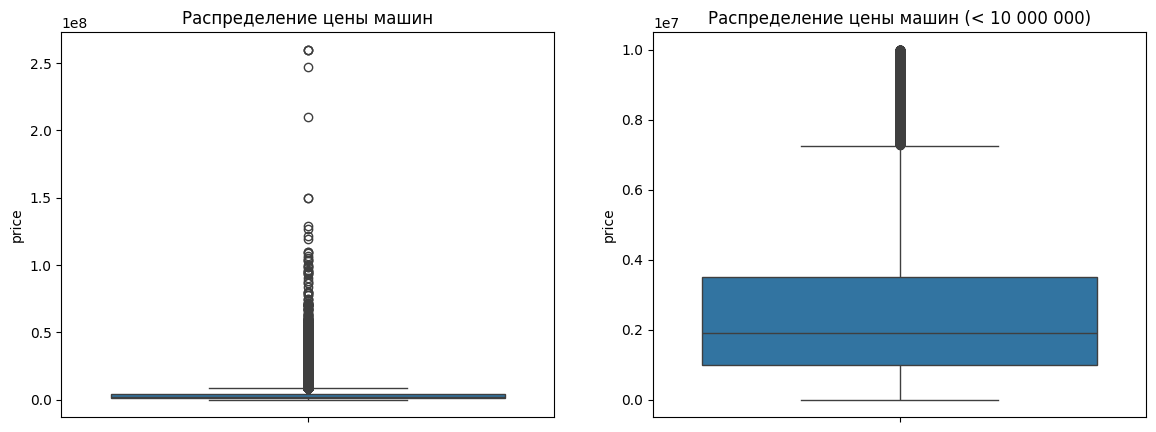

In [93]:
fig = plt.figure(figsize=(14, 5))

ax_1 = plt.subplot(1, 2, 1)
sns.boxplot(df.price)

plt.title("Распределение цены машин")

ax_2 = plt.subplot(1, 2, 2)
sns.boxplot(df[df.price < 10_000_000].price)

plt.title("Распределение цены машин (< 10 000 000)")
plt.yscale()

plt.show()

Кажется, что здесь есть большое количетсво выбросов, по цене автомобиля, что может плохо сказаться на работе модели

In [119]:
IQR = df.price.quantile(0.75) - df.price.quantile(0.25)
highest_price = df.price.quantile(0.75) + IQR * 3
print(f"Количество машин, дороже {int(highest_price)} (75-квантиль + 3 межквар. интервала): \t{df[df.price > highest_price].shape[0]}")

Количество машин, дороже 13100000 (75-квантиль + 3 межквар. интервала): 	4469


Предлагаю считать выбросами все, что лежит выше (75-квантиля + 3 межквартильных интервала)

Если нам так же важно предсказывать более дорогие авто, то я бы завел отдельную модель для этого.

In [121]:
df = df[df.price <= highest_price]

## Year

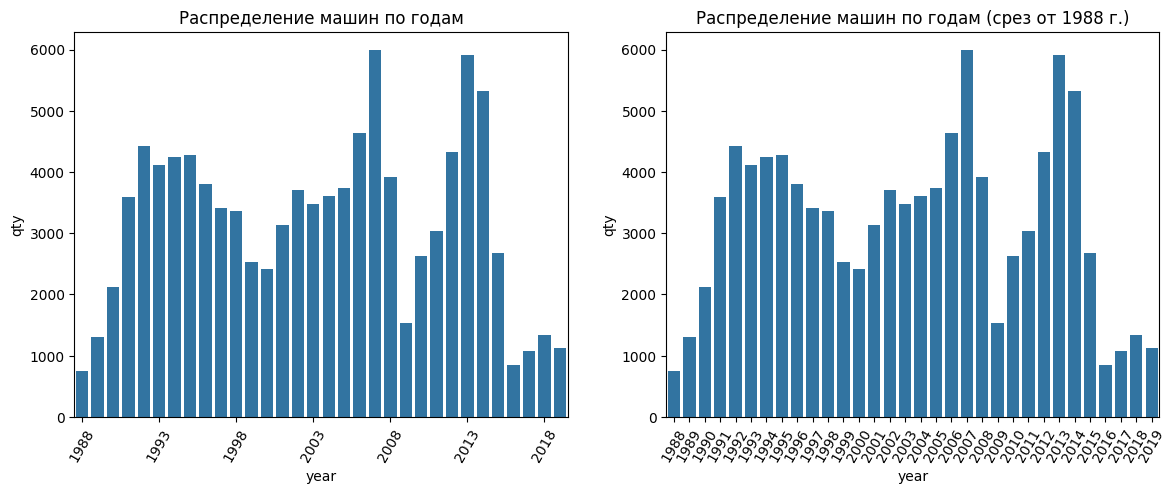

In [130]:
year_groupby = df.groupby("year", as_index=False).model \
    .count() \
    .rename(columns={"model": "qty"})

fig = plt.figure(figsize=(14, 5))

ax_1 = plt.subplot(1, 2, 1)
sns.barplot(data=year_groupby, x="year", y="qty")

plt.title("Распределение машин по годам")
plt.xticks(ticks=[i for i in range(len(year_groupby))][::5], rotation=60)


ax_2 = plt.subplot(1, 2, 2)
sns.barplot(data=year_groupby[year_groupby.year >=1988], x="year", y="qty")

plt.title("Распределение машин по годам (срез от 1988 г.)")
plt.xticks(rotation=60)

plt.show()

Данные предоставленны о машинах до 2019 года. Наиболее часто встречаются автомобили 2013 года производства

In [75]:
print(f"Машин < 1988 года: \t{df[df.year < 1988].shape[0]}")

Машин < 1988 года: 	1611


Обрежу датасет по 1988 год, поскольку до 1988 мало данных + это в основном ретро-автомобили, либо ошибки в данных

Нам важнее предсказывать точно более свежие машины, а если важно уметь предсказывать ретро-автомобили, то я бы завел для этого отдельную модель

In [77]:
df = df[df.year >= 1988]

## Brand

Кажется, что цена машины зависит от ее марки

In [125]:
df.head(1)

,brand,description,model,price,year,city,transmission,body,drive,cleared,wheel,color,mileage,liters,fuel
0,Mercedes-Benz,"полный электропакет , налог уплачен, техосмот...",GL 550,5800000,2008,Актау,типтроник,внедорожник,полный привод,Да,слева,черный металлик,NaN,5.5,бензин


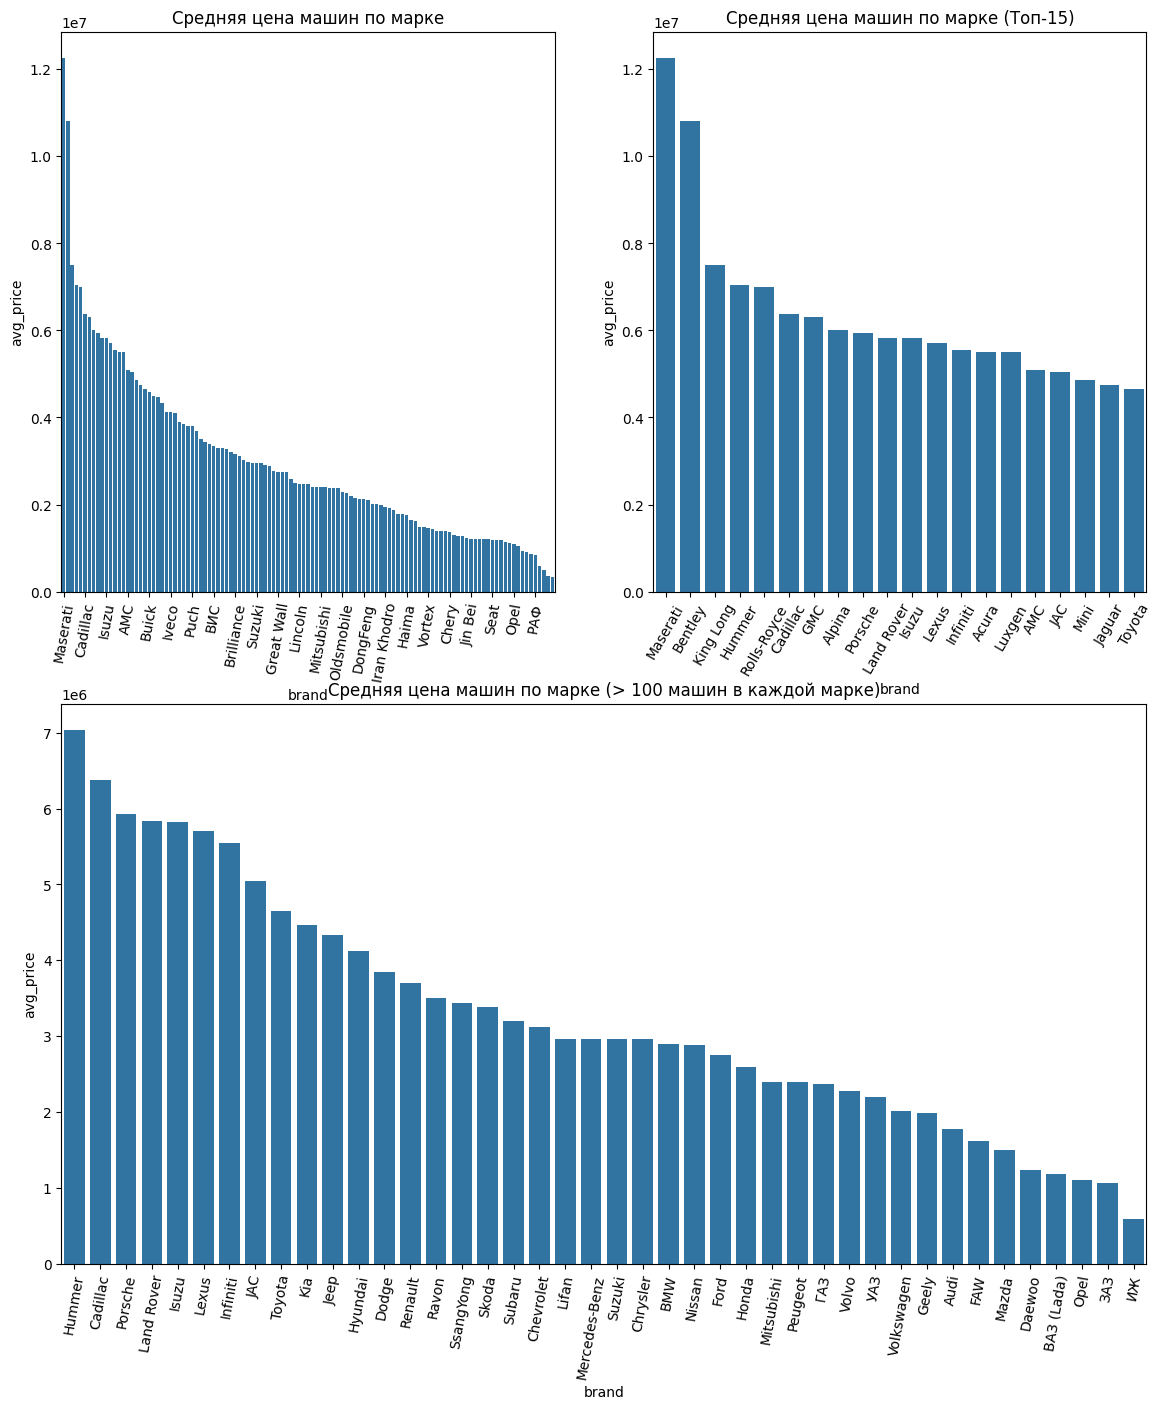

In [194]:
brand_price_groupby = df.groupby("brand", as_index=False) \
    .agg({"price": "mean", "year": "count"}) \
    .rename(columns={"price": "avg_price", "year": "qty"}) \
    .sort_values("avg_price", ascending=False)
order = brand_price_groupby.brand.tolist()

fig = plt.figure(figsize=(14, 16))

ax_1 = plt.subplot(2, 2, 1)
sns.barplot(data=brand_price_groupby, x="brand", y="avg_price")

plt.title("Средняя цена машин по марке")
plt.xticks(ticks=[i for i in range(len(brand_price_groupby))][::5], rotation=80)


ax_2 = plt.subplot(2, 2, 2)
sns.barplot(data=brand_price_groupby[:20], x="brand", y="avg_price")

plt.title("Средняя цена машин по марке (Топ-15)")
plt.xticks(rotation=60)


ax_3 = plt.subplot(2, 1, 2)

sns.barplot(data=brand_price_groupby[brand_price_groupby.qty > 100], x="brand", y="avg_price")

plt.title("Средняя цена машин по марке (> 100 машин в каждой марке)")
plt.xticks(rotation=80)

plt.show()

В самом деле марка автомобиля влияет на цену автомобиля, поэтому это хороший признак, который мы оставим

In [199]:
df.brand.nunique()

115

## Color

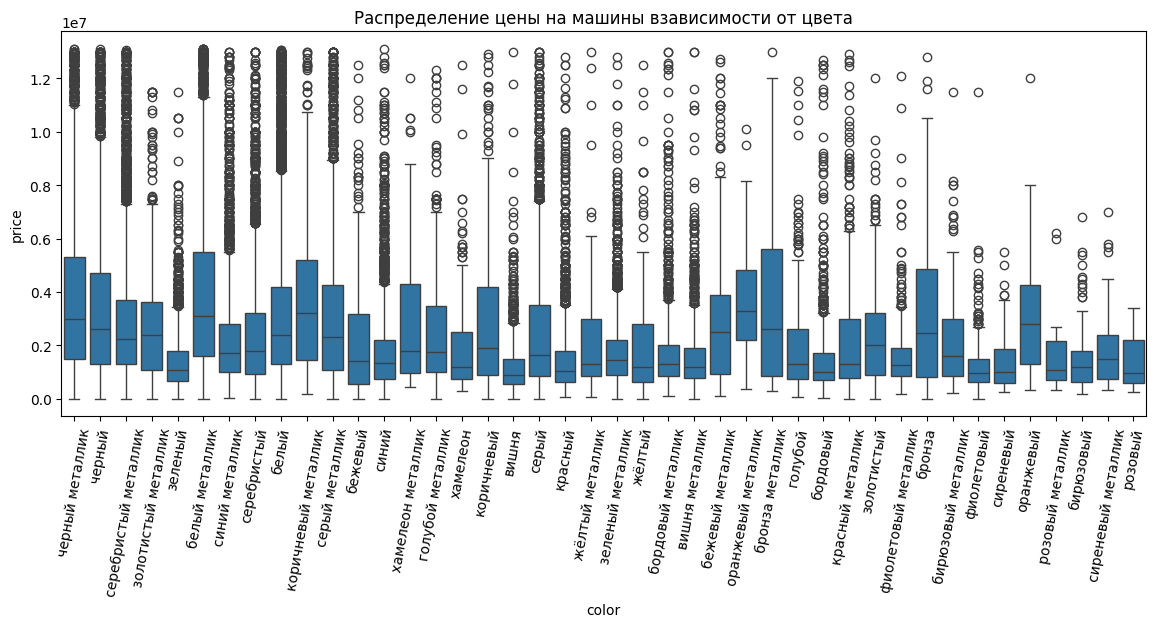

In [530]:
fig = plt.figure(figsize=(14, 5))

sns.boxplot(data=df, x="color", y="price")

plt.title("Распределение цены на машины взависимости от цвета")
plt.xticks(rotation=80)

plt.show()

Видно что взависимости от цвета авто, разное распределение таргета, поэтому фича `color` должна быть довольно полезной

# Train Test Split

In [540]:
X = df.drop("price", axis=1)
y = df.price

In [541]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

На всякий случай проверим распределение таргета в трейне и тесте

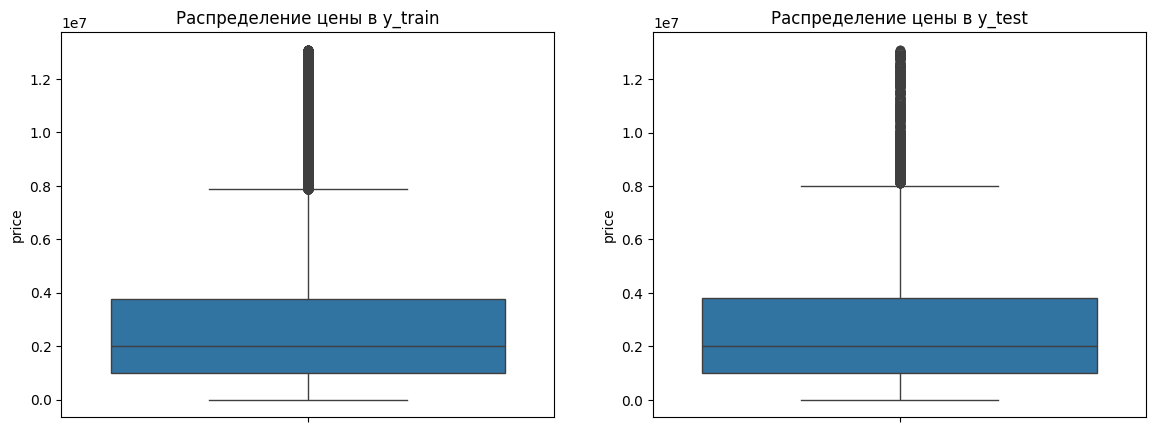

In [542]:
fig = plt.figure(figsize=(14, 5))

ax_1 = plt.subplot(1, 2, 1)
sns.boxplot(y_train)

plt.title("Распределение цены в y_train")

ax_1 = plt.subplot(1, 2, 2)
sns.boxplot(y_test)

plt.title("Распределение цены в y_test")

plt.show()

# Missing data

Поработаем с пропусками в данных

In [543]:
print("Количество пропусков в данных по колонкам (проценты):")

print(round(df.isnull().sum() / len(df) * 100, 1).astype("str") + " %")

Количество пропусков в данных по колонкам (проценты):
brand            0.0 %
description      4.9 %
model            0.0 %
price            0.0 %
year             0.0 %
city             0.0 %
transmission     0.0 %
body             0.0 %
drive           12.4 %
cleared          0.0 %
wheel            0.0 %
color            9.5 %
mileage         40.0 %
liters           0.0 %
fuel             0.0 %
dtype: object


In [544]:
df.isnull().sum()

brand               0
description      5008
model              37
price               0
year                0
city                0
transmission        0
body                0
drive           12663
cleared             0
wheel               5
color            9735
mileage         40983
liters             22
fuel               22
dtype: int64

In [545]:
df.head(2)

,brand,description,model,price,year,city,transmission,body,drive,cleared,wheel,color,mileage,liters,fuel
0,Mercedes-Benz,"полный электропакет , налог уплачен, техосмот...",GL 550,5800000,2008,Актау,типтроник,внедорожник,полный привод,Да,слева,черный металлик,NaN,5.5,бензин
1,BMW,"тонировка , обогрев зеркал, хрустальная оптик...",X5,5500000,2009,Нур-Султан (Астана),автомат,кроссовер,полный привод,Да,слева,черный,170.0,4.8,бензин


In [546]:
X_train.drive.mode()[0]

'передний привод'

**Заполним пропуски. Агрегировать данные будем на X_train, и использовать именно их для заполнения пропусков как в X_train, так и в X_test**

`drive` заполним наиболее встречающимся значением в категории brand-model-year, а если в какой-то из категорий будет пропущенное агрегированное значение, то заполним оставшиеся пропуски модой в колонке drive - "передний привод"

`mileage` заполним средним значением пробега за каждый код

Пропуски в колонке `description` заполним просто пустой строкой

`color` заполним модой по колонке

In [547]:
drive_grouped_values = X_train.groupby(["brand", "model", "year"]).drive \
    .apply(lambda x: x.mode()[0] if not x.mode().empty else np.nan) \
    .fillna(df.drive.mode()[0])

drive_mode = X_train.drive.mode()[0]

def fill_missing_drive(row):
    """Fill missing drive based on its brand, model, year"""
    if pd.isna(row['drive']):
        return drive_grouped_values.get((row["brand"], row["model"], row["year"]), drive_mode)  # default_value - это значение по умолчанию
    return row['drive']

In [548]:
mileage_grouped_values = X_train.groupby("year").mileage.mean().astype(int).to_dict()
mileage_mean = X_train.mileage.mean()

def fill_missing_mileage(row):
    """Fill missing drive based on its year"""
    if pd.isna(row['mileage']):
        return mileage_grouped_values.get(row["year"], mileage_mean)
    return row['mileage']

In [549]:
color_mode = X_train.color.mode()[0]

In [552]:
X_train.apply(fill_missing_drive, axis=1).head(2)

62192    передний привод
3329       полный привод
dtype: object

In [553]:
X_train["description"] = X_train["description"].fillna("")
X_test["description"] = X_test["description"].fillna("")

X_train["color"] = X_train["color"].fillna(color_mode)
X_test["color"] = X_test["color"].fillna(color_mode)

X_train["drive"] = X_train.apply(fill_missing_drive, axis=1)
X_test["drive"] = X_test.apply(fill_missing_drive, axis=1)

X_train["mileage"] = X_train.apply(fill_missing_mileage, axis=1).astype(int)
X_test["mileage"] = X_test.apply(fill_missing_mileage, axis=1).astype(int)

Строки, где пропущены `model`, `wheel`, `liters`, `fuel` для простоты удалим, поскольку их не так много, относительно выборки

In [554]:
for col in ["model", "wheel", "liters", "fuel"]:
    train_indexes = X_train[X_train[col].isna()].index
    test_indexes = X_test[X_test[col].isna()].index

    X_train = X_train.drop(train_indexes)
    X_test = X_test.drop(test_indexes)

    y_train = y_train.drop(train_indexes)
    y_test = y_test.drop(test_indexes)

In [557]:
X_train.isna().sum()

brand           0
description     0
model           0
year            0
city            0
transmission    0
body            0
drive           0
cleared         0
wheel           0
color           0
mileage         0
liters          0
fuel            0
dtype: int64

С пропусками разобрались, перейдем к фичам

# Feature Engineering

In [558]:
X_train.head(2)

,brand,description,model,year,city,transmission,body,drive,cleared,wheel,color,mileage,liters,fuel
62192,ВАЗ (Lada),"Один хозяин, в родной краске, автозапуск, торг.",2170 (седан),2015,Усть-Каменогорск,механика,седан,передний привод,Да,слева,белый,83200,1.6,бензин
3329,Land Rover,"тонировка, люк , ксенон, корректор фар, проти...",Range Rover,2007,Нур-Султан (Астана),автомат,внедорожник,полный привод,Да,слева,черный металлик,201791,4.4,бензин


**Кажется, что возраст автомобиля был бы хорошей фичей**

(Есть вероятность, что данные собирались в 2019 году, поскольку предоставлены машины до 2019 года включительно, что значит, например, что возраст машины 2019-года должен быть 0, но тем не менее я буду считать возраст для 2024 года, то есть 2024 - 2019 = 5)

In [559]:
X_train["age"] = 2024 - X_train["year"]
X_test["age"] = 2024 - X_test["year"]

X_train = X_train.drop("year", axis=1)
X_test = X_test.drop("year", axis=1)

Также имеет смысл объеденить `brand` и `model` в одну колонку

In [560]:
X_train["brand_model"] = X_train["brand"] + "_" + X_train["model"]
X_test["brand_model"] = X_test["brand"] + "_" + X_test["model"]

X_train = X_train.drop(["brand", "model"], axis=1)
X_test = X_test.drop(["brand", "model"], axis=1)

In [561]:
X_train.head(2)

,description,city,transmission,body,drive,cleared,wheel,color,mileage,liters,fuel,age,brand_model
62192,"Один хозяин, в родной краске, автозапуск, торг.",Усть-Каменогорск,механика,седан,передний привод,Да,слева,белый,83200,1.6,бензин,9,ВАЗ (Lada)_2170 (седан)
3329,"тонировка, люк , ксенон, корректор фар, проти...",Нур-Султан (Астана),автомат,внедорожник,полный привод,Да,слева,черный металлик,201791,4.4,бензин,17,Land Rover_Range Rover


Также колонка `description` может дать полезную информацию

In [562]:
print(f"Количество пропущенных данных в description колонке в общих данных: \t{df.description.isna().sum()}")

Количество пропущенных данных в description колонке в общих данных: 	5008


**Как вариант достать ключевые слова, например, про какие-то аварии, царапины и тд, и сделать бинарную фичу/фичи.**

Вот так можно, например, реализовать это:

In [563]:
def find_repair_info(description):
    if pd.isnull(description):
        return None

    repair_keywords = ['ремонт', 'авария', 'поврежден', 'столкновение', 'ДТП', 'вмятина', 'царапина', 'замена']

    repair_regex = '|'.join(repair_keywords)

    if re.search(repair_regex, description, re.IGNORECASE):
        return 1
    else:
        return 0

In [564]:
has_defect = X_train.description.apply(find_repair_info)
has_defect.head(3)

62192    0
3329     1
16403    0
Name: description, dtype: int64

In [565]:
has_defect.value_counts()

description
0    77532
1     4382
Name: count, dtype: int64

In [566]:
print(has_defect)

62192     0
3329      1
16403     0
67410     0
43800     0
         ..
54592     0
104017    0
6410      0
83129     0
104522    0
Name: description, Length: 81914, dtype: int64


Минус конкретно такой реализации, что, например, фразу "ремонт не требуется" мы тоже поймаем, поэтому сейчас использовать я это не буду

*Также было бы классно иметь модель, которая может определять семантику описания - кажется, что это было бы неплохой фичей*

**Я предлагаю завести TF-IDF и достать из векторов mean, max значения в качестве фичей. Полностью кидать огроменную матрицу в фичи я не хоче, поэтому можно попробовать уменьшить размерность с помощью PCA. Возможно такой подход даст прирост в качестве**

In [567]:
X_train.head(2)

,description,city,transmission,body,drive,cleared,wheel,color,mileage,liters,fuel,age,brand_model
62192,"Один хозяин, в родной краске, автозапуск, торг.",Усть-Каменогорск,механика,седан,передний привод,Да,слева,белый,83200,1.6,бензин,9,ВАЗ (Lada)_2170 (седан)
3329,"тонировка, люк , ксенон, корректор фар, проти...",Нур-Султан (Астана),автомат,внедорожник,полный привод,Да,слева,черный металлик,201791,4.4,бензин,17,Land Rover_Range Rover


In [568]:
def clean_text(text):
    text = text.lower().strip()

    text = text.translate(str.maketrans('', '', string.punctuation))

    words = word_tokenize(text)

    # Удаление цифр (опционально)
    text = re.sub(r'\d+', '', text)

    # Лемматизация
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    text = ' '.join(words)

    return text

In [569]:
X_train['cleaned_description'] = X_train['description'].apply(clean_text)
X_test['cleaned_description'] = X_test['description'].apply(clean_text)

In [570]:
X_train.head(2)

,description,city,transmission,body,drive,cleared,wheel,color,mileage,liters,fuel,age,brand_model,cleaned_description
62192,"Один хозяин, в родной краске, автозапуск, торг.",Усть-Каменогорск,механика,седан,передний привод,Да,слева,белый,83200,1.6,бензин,9,ВАЗ (Lada)_2170 (седан),один хозяин в родной краске автозапуск торг
3329,"тонировка, люк , ксенон, корректор фар, проти...",Нур-Султан (Астана),автомат,внедорожник,полный привод,Да,слева,черный металлик,201791,4.4,бензин,17,Land Rover_Range Rover,тонировка люк ксенон корректор фар противотума...


In [571]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

tfidf_matrix_train = tfidf_vectorizer.fit_transform(X_train["cleaned_description"])
tfidf_matrix_test = tfidf_vectorizer.transform(X_test["cleaned_description"])

In [572]:
# Преобразование в плотную матрицу
dense_tfidf_matrix_train = tfidf_matrix_train.toarray()
dense_tfidf_matrix_test = tfidf_matrix_test.toarray()

In [573]:
# PCA
pca = PCA(n_components=10)

In [574]:
REDUCED_MATRIX_TRAIN = pca.fit_transform(dense_tfidf_matrix_train)
REDUCED_MATRIX_TEST = pca.transform(dense_tfidf_matrix_test)

In [575]:
X_train = X_train.drop(["description", "cleaned_description"], axis=1)
X_test = X_test.drop(["description", "cleaned_description"], axis=1)

Итого мы получили новые фичи из `description`на основе TF-IDF, прогнанного через PCA для уменьшения размерности. Можно экспериментировать с параметрами, но я буду использовать такие.

Выдели еще фичи из TF-IDF представления:

In [576]:
MEAN_TF_IDF_TRAIN = dense_tfidf_matrix_train.mean(1)
MEAN_TF_IDF_TEST = dense_tfidf_matrix_test.mean(1)

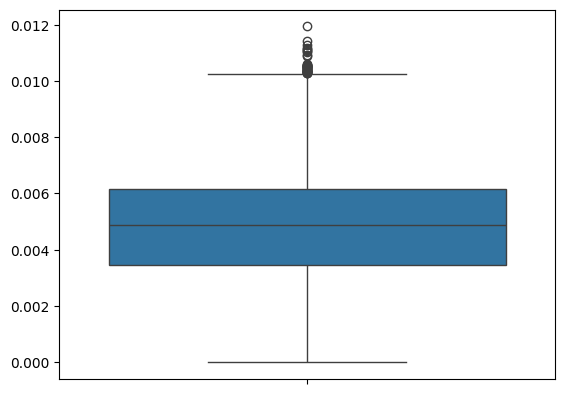

In [577]:
sns.boxplot(MEAN_TF_IDF_TRAIN);

<Axes: >

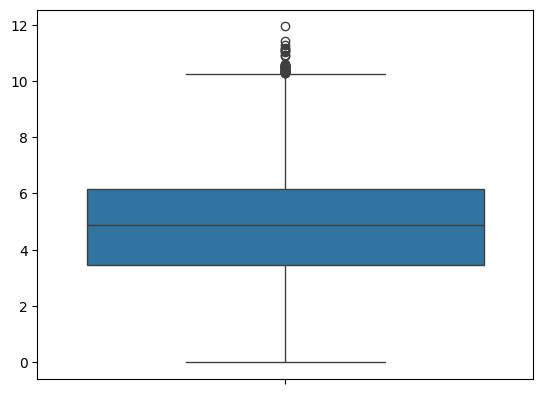

In [578]:
sns.boxplot(dense_tfidf_matrix_train.sum(1))

Нет смысла брать в качестве фичей как среднее так и сумму по TF-IDF векторам, так как распределения у них похожи, различаются только порядки.

Поэтому оставим фичу `mean_tf_idf`

In [579]:
X_train["mean_tf_idf"] = MEAN_TF_IDF_TRAIN
X_test["mean_tf_idf"] = MEAN_TF_IDF_TEST

In [580]:
X_train.head(2)

,city,transmission,body,drive,cleared,wheel,color,mileage,liters,fuel,age,brand_model,mean_tf_idf
62192,Усть-Каменогорск,механика,седан,передний привод,Да,слева,белый,83200,1.6,бензин,9,ВАЗ (Lada)_2170 (седан),0.002361
3329,Нур-Султан (Астана),автомат,внедорожник,полный привод,Да,слева,черный металлик,201791,4.4,бензин,17,Land Rover_Range Rover,0.007676


# Encoding

Посмотрим сколько уникальных значений в каждой фиче:

In [581]:
cat_features_to_encode = ["city", "transmission", "body", "drive", "cleared", "wheel", "color", "liters", "fuel", "brand_model"]

for cat_feat in cat_features_to_encode:
    print(f"Количество уникальных значений в колонке {cat_feat}: {pd.concat([X_train, X_test])[cat_feat].nunique()}")

Количество уникальных значений в колонке city: 310
Количество уникальных значений в колонке transmission: 7
Количество уникальных значений в колонке body: 15
Количество уникальных значений в колонке drive: 3
Количество уникальных значений в колонке cleared: 2
Количество уникальных значений в колонке wheel: 2
Количество уникальных значений в колонке color: 42
Количество уникальных значений в колонке liters: 152
Количество уникальных значений в колонке fuel: 6
Количество уникальных значений в колонке brand_model: 1556


Декодируем бинарные фичи

In [582]:
X_train["cleared"] = X_train["cleared"].apply(lambda x: 1 if x == "Да" else 0)
X_test["cleared"] = X_test["cleared"].apply(lambda x: 1 if x == "Да" else 0)

X_train["wheel"] = X_train["wheel"].apply(lambda x: 0 if x == "слева" else 1)
X_test["wheel"] = X_test["wheel"].apply(lambda x: 0 if x == "слева" else 1)

Видно, что колонки `city`, `liters` и `brand_model` большое количество уникальных значений, а также это довольно важные фичи, поэтому для я думаю будет идеально использовать Target Encoding 

`color`, `transmission`, `body`, `drive`, `fuel` декодирую при помощи OneHotEncoding

In [632]:
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

In [583]:
te_features = ["city", "liters", "brand_model"]
ohe_features = ["color", "transmission", "body", "drive", "fuel"]

In [636]:
for feature in te_features:
    encoder = TargetEncoder()
    X_train_enc[feature] = encoder.fit_transform(X_train[feature], y_train)
    X_test_enc[feature] = encoder.transform(X_test_enc[feature])

In [667]:
for feature in ohe_features:
    ohe = OneHotEncoder(drop="first")
    train_encodings = ohe.fit_transform(X_train_enc[[feature]]).toarray()
    test_encodings = ohe.transform(X_test_enc[[feature]]).toarray()

    encoded_df_train = pd.DataFrame(train_encodings, columns=ohe.get_feature_names_out([feature]))
    encoded_df_train.index = X_train_enc.index

    encoded_df_test = pd.DataFrame(test_encodings, columns=ohe.get_feature_names_out([feature]))
    encoded_df_test.index = X_test_enc.index
    
    # Объединение с исходным DataFrame
    X_train_enc = pd.concat([X_train_enc, encoded_df_train], axis=1)
    X_test_enc = pd.concat([X_test_enc, encoded_df_test], axis=1)

# Modeling